In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

import mglearn
import spacy
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, recall_score, precision_recall_curve, roc_auc_score, accuracy_score, f1_score

In [44]:
fN = '/Users/anaso/Documents/AA/AA-22-23/Trabalho Final/imdbFull.p'

D = pickle.load(open(fN, 'rb'))

max_criticas = 2000
corpus = D.data[:max_criticas]
y = D.target[:max_criticas]

print("Tamanho corpus: {} documentos".format(len(corpus)))
print("Distribuição de classes: ", np.bincount(y))

Tamanho corpus: 2000 documentos
Distribuição de classes:  [  0 422 169 164 240   0   0 201 246 171 387]


In [45]:
# Limpeza de dados
corpus = [critica.replace("<br />", " ") for critica in corpus]
corpus = [" ".join((palavra if palavra not in stop_words else " ") for palavra in critica.split()) for critica in corpus]
corpus = [" ".join(lemma.lemmatize(palavra) for palavra in critica.split()) for critica in corpus]

In [48]:
# Separação em treino e teste
corpus_trainval, corpus_test, y_trainval, y_test = train_test_split(corpus, y, test_size=1/3, shuffle=True, stratify=y)
corpus_train, corpus_validation, y_train, y_validation = train_test_split(corpus_trainval, y_trainval, test_size=1/2, shuffle=True, stratify=y_trainval)


In [127]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=5000))
param_grid = {'tfidfvectorizer__min_df': [3, 4, 5], 
                # 'tfidfvectorizer__max_df': [0.85, 0.8],
                'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                'tfidfvectorizer__token_pattern': [r'(\S+)', r'\b[a-zA-Z]{3,}\b', r'\b\w{3,}\b', r'\w{1,}'],  
                
                'logisticregression__C': [0.01, 0.1, 1, 10, 100], 
                'logisticregression__solver': ['liblinear', 'saga'], 
                'logisticregression__multi_class': ['auto', 'ovr'], 
                'logisticregression__penalty': ['l1', 'l2']}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=3)
grid.fit(corpus_validation, y_validation)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 3 folds for each of 720 candidates, totalling 2160 fits
[CV 1/3] END logisticregression__C=0.01, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1), tfidfvectorizer__token_pattern=(\S+);, score=0.211 total time=   0.0s
[CV 2/3] END logisticregression__C=0.01, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1), tfidfvectorizer__token_pattern=(\S+);, score=0.212 total time=   0.0s
[CV 3/3] END logisticregression__C=0.01, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1), tfidfvectorizer__token_pattern=(\S+);, score=0.212 total time=   0.0s
[CV 1/3] END logisticregression__C=0.01, logisticregression__multi_class=auto, logistic

KeyboardInterrupt: 

In [124]:
## Inserir parametros devolvido acima
tf = TfidfVectorizer(min_df=5, ngram_range=(1, 3), token_pattern=r'\b\w{3,}\b').fit(corpus_trainval)
corpus_trainval_p = tf.transform(corpus_trainval)
corpus_test_p = tf.transform(corpus_test)

features_names = tf.get_feature_names_out()

## Inserir parametros devolvido acima
lr = LogisticRegression(max_iter=1000, C=100).fit(corpus_trainval_p, y_trainval)
y_trainval_e = lr.predict(corpus_trainval_p)
y_test_e = lr.predict(corpus_test_p)

pesos = lr.coef_

6167 (6167,)


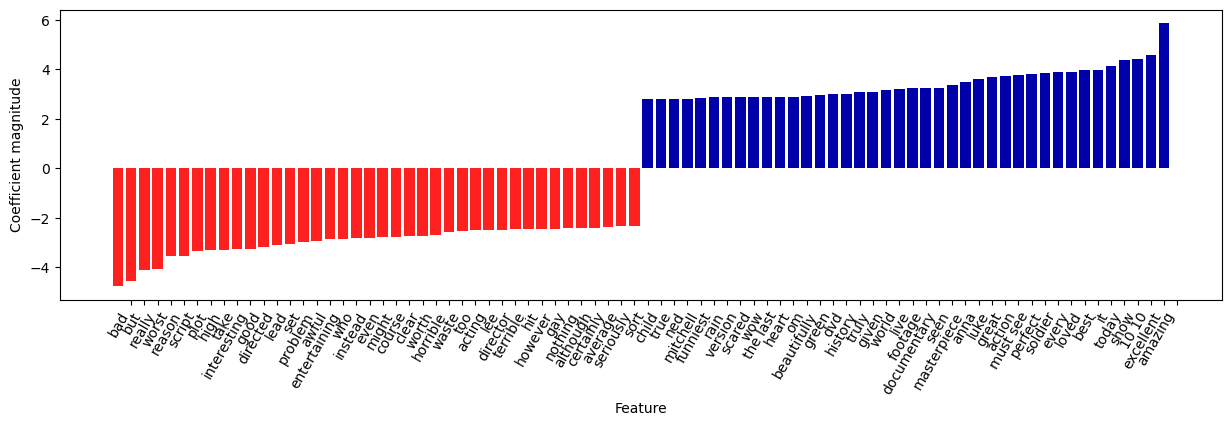

In [105]:
print(len(features_names), pesos[0].shape)
mglearn.tools.visualize_coefficients(pesos[7], features_names, n_top_features=40)

Treino:
Accuracy: 1.0
F1-Score: 1.0
Número total de erros: 0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       281
           2       1.00      1.00      1.00       113
           3       1.00      1.00      1.00       109
           4       1.00      1.00      1.00       160
           7       1.00      1.00      1.00       134
           8       1.00      1.00      1.00       164
           9       1.00      1.00      1.00       114
          10       1.00      1.00      1.00       258

    accuracy                           1.00      1333
   macro avg       1.00      1.00      1.00      1333
weighted avg       1.00      1.00      1.00      1333



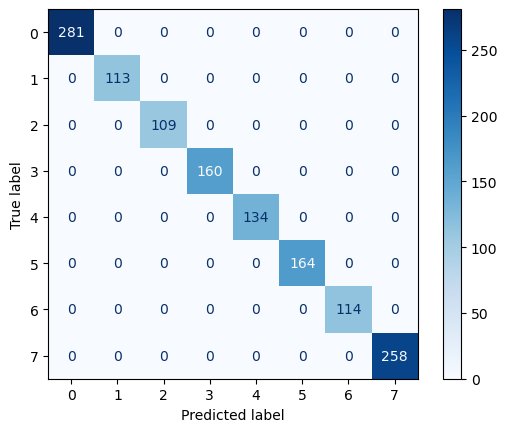

In [125]:
print("Treino:")
print("Accuracy: {}".format(accuracy_score(y_trainval, y_trainval_e)))
print("F1-Score: {}".format(f1_score(y_trainval, y_trainval_e, average='weighted')))
print("Número total de erros: {}".format(np.sum(y_trainval != y_trainval_e)))
print(classification_report(y_trainval, y_trainval_e))
disp = ConfusionMatrixDisplay(confusion_matrix(y_trainval, y_trainval_e))
disp.plot(cmap='Blues')

Teste:
Accuracy: 0.37631184407796103
F1-Score: 0.33688726877369324
Número total de erros: 416
              precision    recall  f1-score   support

           1       0.51      0.72      0.60       141
           2       0.14      0.05      0.08        56
           3       0.14      0.05      0.08        55
           4       0.28      0.33      0.30        80
           7       0.28      0.16      0.21        67
           8       0.26      0.26      0.26        82
           9       0.19      0.09      0.12        57
          10       0.43      0.62      0.51       129

    accuracy                           0.38       667
   macro avg       0.28      0.29      0.27       667
weighted avg       0.32      0.38      0.34       667



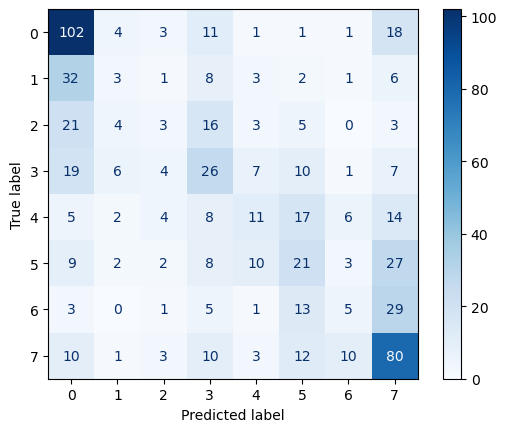

In [126]:
print("Teste:")
print("Accuracy: {}".format(accuracy_score(y_test, y_test_e)))
print("F1-Score: {}".format(f1_score(y_test, y_test_e, average='weighted')))
print("Número total de erros: {}".format(np.sum(y_test != y_test_e)))
print(classification_report(y_test, y_test_e))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_e))
disp.plot(cmap='Blues')

In [ ]:
w = lr.coef_

## Term Frequency–Inverse Document Frequency (TFIDF)

- Número máximo de tokens (max_features)

In [11]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10000))
param_grid = {"logisticregression__C": [0.1, 1, 10, 100], 
                "tfidfvectorizer__max_features": [5000, 7000, 10000, 30000, 90000]}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3)
grid.fit(corpus, y)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=5000;, score=0.350 total time=   0.5s
[CV 2/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=5000;, score=0.343 total time=   0.4s
[CV 3/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=5000;, score=0.335 total time=   0.3s
[CV 4/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=5000;, score=0.323 total time=   0.4s
[CV 5/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=5000;, score=0.340 total time=   0.3s
[CV 1/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=7000;, score=0.350 total time=   0.5s
[CV 2/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=7000;, score=0.340 total time=   0.4s
[CV 3/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=7000;, score=0.333 total time=   0.4s
[CV 4/5] END logisticregression__C=0.1, tfidfvectorizer__max_features=7000

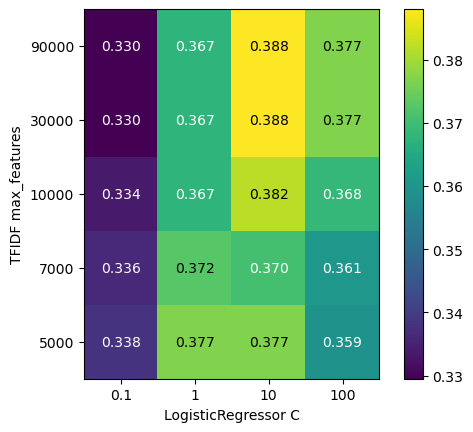

In [12]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 5).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel="LogisticRegressor C", ylabel="TFIDF max_features", cmap="viridis", fmt="%.3f", 
    xticklabels=param_grid["logisticregression__C"], 
    yticklabels=param_grid["tfidfvectorizer__max_features"]
)
plt.colorbar(heatmap)

In [13]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10000))
param_grid = {"logisticregression__C": [10], 
                "tfidfvectorizer__max_features": [1000, 2000, 3000, 4000, 5000]}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3)
grid.fit(corpus, y)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_features=1000;, score=0.312 total time=   0.6s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_features=1000;, score=0.357 total time=   0.7s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_features=1000;, score=0.360 total time=   0.6s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_features=1000;, score=0.345 total time=   0.5s
[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_features=1000;, score=0.350 total time=   0.5s
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_features=2000;, score=0.328 total time=   1.3s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_features=2000;, score=0.388 total time=   1.1s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_features=2000;, score=0.365 total time=   0.8s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_features=2000;, score=0.

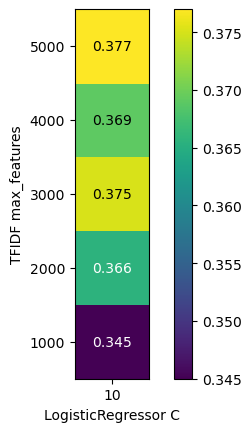

In [14]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 5).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel="LogisticRegressor C", ylabel="TFIDF max_features", cmap="viridis", fmt="%.3f", 
    xticklabels=param_grid["logisticregression__C"], 
    yticklabels=param_grid["tfidfvectorizer__max_features"]
)
plt.colorbar(heatmap)

In [15]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10000))
param_grid = {"logisticregression__C": [10], 
                "tfidfvectorizer__max_features": [100, 300, 500, 700, 1000, 5000]}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3)
grid.fit(corpus, y)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_features=100;, score=0.250 total time=   0.3s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_features=100;, score=0.292 total time=   0.2s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_features=100;, score=0.315 total time=   0.3s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_features=100;, score=0.273 total time=   0.2s
[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_features=100;, score=0.290 total time=   0.2s
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_features=300;, score=0.273 total time=   0.3s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_features=300;, score=0.300 total time=   0.3s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_features=300;, score=0.300 total time=   0.4s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_features=300;, score=0.285 total

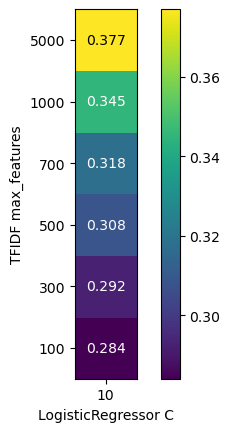

In [16]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 6).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel="LogisticRegressor C", ylabel="TFIDF max_features", cmap="viridis", fmt="%.3f", 
    xticklabels=param_grid["logisticregression__C"], 
    yticklabels=param_grid["tfidfvectorizer__max_features"]
)
plt.colorbar(heatmap)

<b>NOTAS: </b>
- Podemos observar, pelos gráficos anteriores, que abaixo de 100 features a precisão do classificador binário do discriminante logístico diminui consideravelmente. 

- Document Frequency (Minimo e Máximo)

In [17]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10000))
param_grid = {"logisticregression__C": [10], 
                "tfidfvectorizer__min_df": [1, 5, 10, 15], 
                "tfidfvectorizer__max_df": [0.95, 0.9, 0.85, 0.8, 0.7, 0.6]}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3)
grid.fit(corpus, y)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.343 total time=   4.1s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.383 total time=   4.2s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.400 total time=   4.4s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.407 total time=   3.9s
[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.407 total time=   3.7s
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=5;, score=0.335 total time=   1.0s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=5;, score=0.375 total time=   1.1s
[CV 3/5] END logisticregression__C=10, tfi

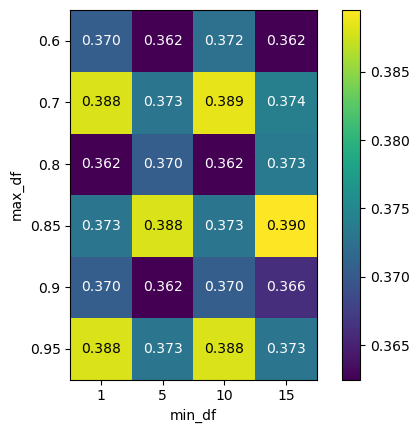

In [18]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 6).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel="min_df", ylabel="max_df", cmap="viridis", fmt="%.3f", 
    xticklabels=param_grid["tfidfvectorizer__min_df"], 
    yticklabels=param_grid["tfidfvectorizer__max_df"]
)
plt.colorbar(heatmap)

In [19]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10000))
param_grid = {"logisticregression__C": [10], 
               "tfidfvectorizer__min_df": [1, 2, 3, 4, 5], 
                "tfidfvectorizer__max_df": [0.95, 0.9, 0.85, 0.8]}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3)
grid.fit(corpus, y)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.343 total time=   4.2s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.383 total time=   4.2s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.400 total time=   3.9s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.407 total time=   3.3s
[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.407 total time=   3.2s
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=2;, score=0.338 total time=   1.6s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=2;, score=0.393 total time=   1.9s
[CV 3/5] END logisticregression__C=10, tfi

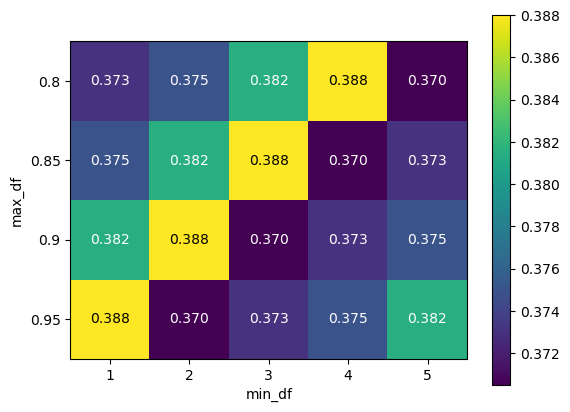

In [23]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 4).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel="min_df", ylabel="max_df", cmap="viridis", fmt="%.3f", 
    xticklabels=param_grid["tfidfvectorizer__min_df"], 
    yticklabels=param_grid["tfidfvectorizer__max_df"]
)
plt.colorbar(heatmap)

In [21]:
tf = grid.best_estimator_['tfidfvectorizer']
print("Tamanho do dicionário: {}".format(len(tf.get_feature_names_out())))



Tamanho do dicionário: 24733


- Token Pattern

Avaliar: 
- r'(\S+)'
- r'\b[a-zA-Z]{3,}\b'
- r'\b\w{3,}\b'

- N-Gram

<b>TODO</b>
- Grid Search para n_gram
- Grid Search para token_pattern
- Grid Search para min_dt e max_df


In [22]:
# param_grid = {''}

In [99]:
features = ["Hello", "is", "need", "favor"]
weights = np.array([[0.0, 0.5, 0.2, 0.7], [0.0, 0.0, 0.0, 0.1]])

print(type(pesos))
print(features)
print(weights)
logic = weights != 0
print("Logic: ", logic)

print(features[logic != 0])

<class 'numpy.ndarray'>
['Hello', 'is', 'need', 'favor']
[[0.  0.5 0.2 0.7]
 [0.  0.  0.  0.1]]
Logic:  [[False  True  True  True]
 [False False False  True]]


TypeError: only integer scalar arrays can be converted to a scalar index